# Movie Recommendation System

#### Hi! Choosing a movie is a real struggle for many of us :) So most of the streaming platforms have inbuilt recommendation systems. These systems aim to predict user's interests and recommend items that they'll probably like. Throughout this notebook, we will try to use 2 clustering methods to build our own movie recommender.

#### We are going to use three following data sets:
[Netflix TV Shows and Movies](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?datasetId=2178661&sortBy=voteCount)  
[HBO Max TV Shows and Movies](https://www.kaggle.com/datasets/victorsoeiro/hbo-max-tv-shows-and-movies?select=titles.csv)  
[Amazon Prime TV Shows and Movies](https://www.kaggle.com/datasets/victorsoeiro/amazon-prime-tv-shows-and-movies?select=titles.csv)  

# Table of Contents

* [Data and Library Imports](#1)
* [Exploratory Data Analysis](#2)
* [Feature Engineering](#3)
* [K-Means Model](#4)
* [DBSCAN 10D model](#5)
* [Movie Recommendation Function](#6)

<a id="1"></a> <br>
# Data and Library Imports

### Library Imports

In [1]:
import pandas as pd
import numpy as np
%precision %.4f

import warnings
warnings.filterwarnings('ignore')

# visualisation
import seaborn as sns
sns.set(style="whitegrid")
from matplotlib import pyplot as plt
%matplotlib inline
import missingno as msno

# sklearn
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

### Data imports

In [2]:
df_netflix = pd.read_csv('/kaggle/input/netflix-tv-shows-and-movies/titles.csv')
df_amazon =  pd.read_csv('/kaggle/input/amazon-prime-tv-shows-and-movies/titles.csv')
df_hbo =  pd.read_csv('/kaggle/input/hbo-max-tv-shows-and-movies/titles.csv')

In [3]:
df = pd.concat([df_netflix, df_amazon, df_hbo], axis=0)

In [4]:
df_movies = df.drop_duplicates()

<a id="2"></a> <br>
# Exploratory Data Analysis

#### As the introduction to the data, let's take a look at the first 5 rows and the main characteristics of the dataset.


In [5]:
df_movies.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [6]:
df_movies.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,18980.000000,18980.000000,4208.000000,17107.000000,1.707000e+04,18310.000000,16324.000000
mean,2005.993678,82.325922,2.511882,6.297030,2.274446e+04,14.382219,6.429386
std,22.427074,36.388000,3.414945,1.293704,9.804167e+04,63.474620,1.400020
min,1901.000000,0.000000,1.000000,1.100000,5.000000e+00,0.000011,0.500000
25%,2004.000000,56.000000,1.000000,5.500000,2.090000e+02,1.721000,5.700000
50%,2016.000000,88.000000,1.000000,6.400000,1.116500e+03,4.034000,6.500000
75%,2019.000000,104.000000,3.000000,7.200000,6.876000e+03,10.584500,7.300000
max,2022.000000,549.000000,52.000000,9.900000,2.555504e+06,4447.894000,10.000000


In [7]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18980 entries, 0 to 3293
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    18980 non-null  object 
 1   title                 18979 non-null  object 
 2   type                  18980 non-null  object 
 3   description           18831 non-null  object 
 4   release_year          18980 non-null  int64  
 5   age_certification     8684 non-null   object 
 6   runtime               18980 non-null  int64  
 7   genres                18980 non-null  object 
 8   production_countries  18980 non-null  object 
 9   seasons               4208 non-null   float64
 10  imdb_id               17586 non-null  object 
 11  imdb_score            17107 non-null  float64
 12  imdb_votes            17070 non-null  float64
 13  tmdb_popularity       18310 non-null  float64
 14  tmdb_score            16324 non-null  float64
dtypes: float64(5), int64

#### We can already notice that some of the variables are missing data. Let's count the number of null and missing rows.

In [8]:
df_movies.isna().sum()

id                          0
title                       1
type                        0
description               149
release_year                0
age_certification       10296
runtime                     0
genres                      0
production_countries        0
seasons                 14772
imdb_id                  1394
imdb_score               1873
imdb_votes               1910
tmdb_popularity           670
tmdb_score               2656
dtype: int64

#### Let's visualize missing data, as it's always gives better understanding of the picture.

Text(0.5, 1.0, 'Distribution of Missing Values')

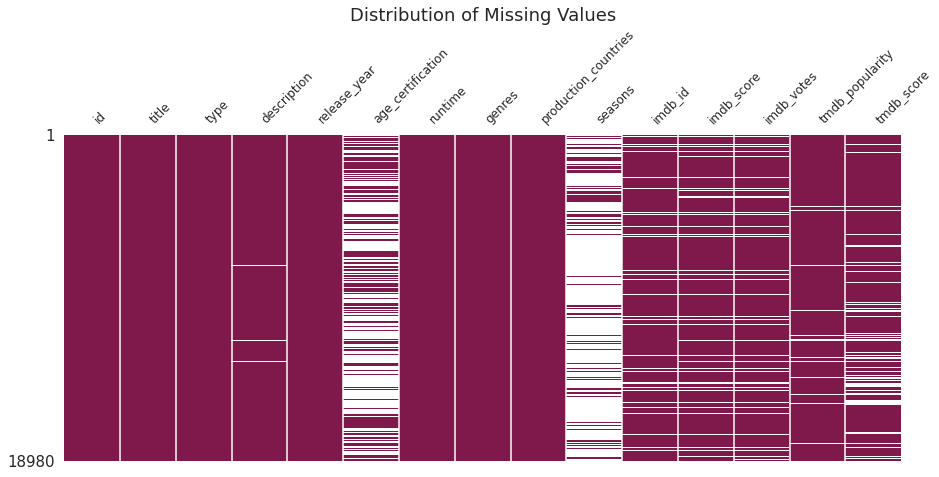

In [9]:
msno.matrix(df_movies, figsize=(15,6), fontsize=12, sparkline=False, color=(0.5, 0.1, 0.3))
plt.title('Distribution of Missing Values', fontsize=18)

#### As we see, couple of variables have big gaps here.  
#### We're going to take a closer look at some of the variables.

### #1 type

In [10]:
df_movies.type.value_counts()

MOVIE    14772
SHOW      4208
Name: type, dtype: int64

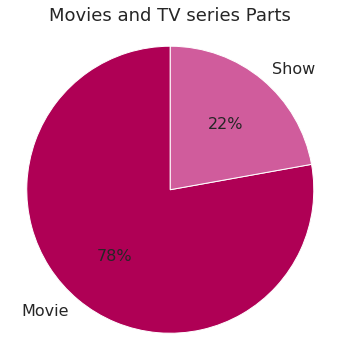

In [11]:
plt.figure(figsize=(10,6))
plt.title('Movies and TV series Parts', fontsize=18)
plt.pie(df_movies.type.value_counts(), 
        labels=['Movie', 'Show'],
        textprops={"fontsize":16},
        radius=1.1, startangle=90,
        colors=['#af0055', '#D05C9C'],
        autopct='%.0f%%')
plt.show()

### #2 description

In [12]:
from wordcloud import WordCloud
descriptions = (pd.DataFrame(df_movies.description.dropna())).reset_index()
mas = []
for i in range(5832):
  w = descriptions.description[i]
  ww = w.split()
  mas.append(ww)

data = []
for i in mas:
    for j in range(len(i)):
        data.append(i[j].lower())
        
big_string=''
for i in range(len(data)):
    big_string+=(data[i]+' ')

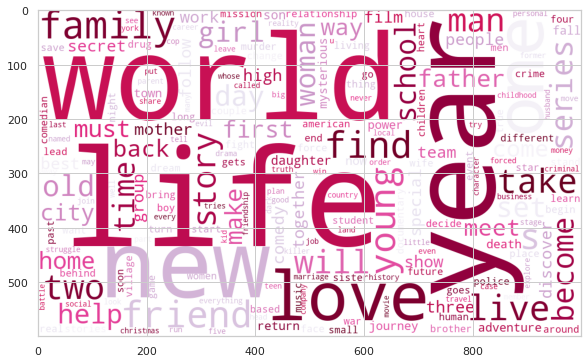

In [13]:
from wordcloud import WordCloud
wordCloud = WordCloud(width = 1000, height = 600, random_state=1, colormap='PuRd', background_color='white', collocations=False).generate(big_string)

plt.figure(figsize=(10,6))
plt.imshow(wordCloud)

#### An interesting variable that could be useful for a future model.
#### However, its processing seems rather complicated (at least, for my current knowledge level), so we'll continue without it.

In [14]:
df_movies.drop('description', axis=1, inplace=True)

### #3 release_year

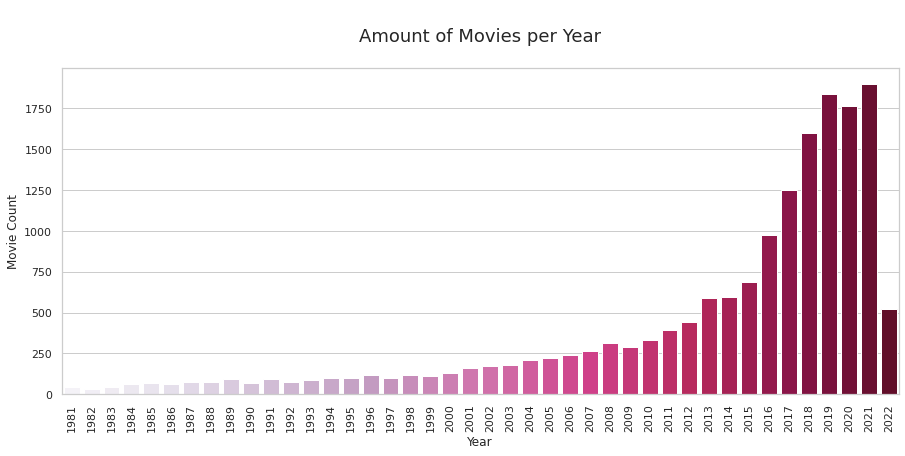

In [15]:
plt.figure(figsize=(15,6))
plt.title('\nAmount of Movies per Year\n', fontsize=18)
sns.countplot(df_movies[df_movies.release_year>1980].release_year, palette='PuRd')
plt.xticks(rotation=90)
plt.xlabel("Year")
plt.ylabel("Movie Count")
plt.show()

#### Amount of the movies increased tremendeouly since even 2010!

### #4 age_certification

In [16]:
print('NaN values in age certification variable:', df_movies.age_certification.isna().sum())
print('This is', round(df_movies.age_certification.isna().sum()/df_movies.age_certification.shape[0]*100),'% of all the values')

NaN values in age certification variable: 10296
This is 54 % of all the values


#### This variable contains too many undefined values, which cannot be filled in at the moment, so it was decided to drop it.

In [17]:
df_movies.drop('age_certification', axis=1, inplace=True)

### #5,6 production_countries and genres

#### These two variables are represented as lists.

#### Therefore, before working with them, the lists must be "unpacked" to strings. We'll also get a single "top" category of a list.

In [18]:
df_movies.head()

,id,title,type,release_year,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,1976,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,1972,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,1975,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,1967,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [19]:
df_movies['production_countries'] = df_movies['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df_movies['lead_prod_country'] = df_movies['production_countries'].str.split(',').str[0]

# Let's also add a number of countries, envolved in movie making, so that we save a little more data
df_movies['prod_countries_cnt'] = df_movies['production_countries'].str.split(',').str.len()

In [20]:
df_movies.lead_prod_country = df_movies.lead_prod_country.replace('', np.nan)

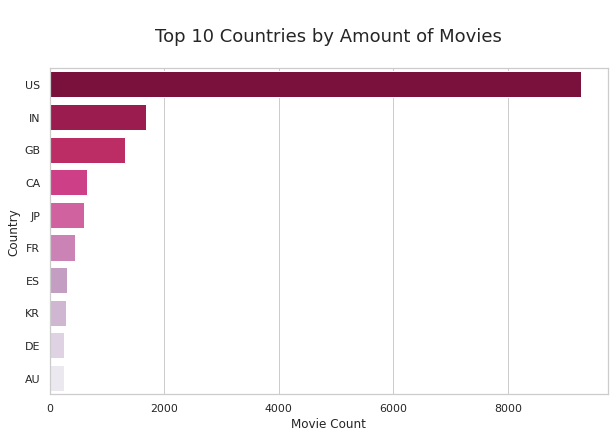

In [21]:
bp_df = pd.DataFrame(df_movies.lead_prod_country.value_counts()).head(10)
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nTop 10 Countries by Amount of Movies\n', fontsize=18)
sns.countplot(y=df_movies.lead_prod_country, palette='PuRd_r', order=order)
plt.xlabel('Movie Count')
plt.ylabel('Country')
plt.show()

#### Similar transformations we'll perform for genre: unpacking the list and leaving one main genre.

In [22]:
df_movies['genres'] = df_movies['genres'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df_movies['main_genre'] = df_movies['genres'].str.split(',').str[0]

In [23]:
df_movies.drop(['genres', 'production_countries'], axis=1, inplace=True)

#### Let's check out the result

In [24]:
df_movies.head()

,id,title,type,release_year,runtime,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,lead_prod_country,prod_countries_cnt,main_genre
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,51,1.0,NaN,NaN,NaN,0.600,NaN,US,1,documentation
1,tm84618,Taxi Driver,MOVIE,1976,114,NaN,tt0075314,8.2,808582.0,40.965,8.179,US,1,drama
2,tm154986,Deliverance,MOVIE,1972,109,NaN,tt0068473,7.7,107673.0,10.010,7.300,US,1,drama
3,tm127384,Monty Python and the Holy Grail,MOVIE,1975,91,NaN,tt0071853,8.2,534486.0,15.461,7.811,GB,1,fantasy
4,tm120801,The Dirty Dozen,MOVIE,1967,150,NaN,tt0061578,7.7,72662.0,20.398,7.600,GB,2,war


In [25]:
df_movies['main_genre'].unique()

array(['documentation', 'drama', 'fantasy', 'war', 'comedy', 'thriller',
       'crime', 'romance', 'action', 'western', 'history', 'music',
       'horror', 'scifi', 'animation', 'family', 'reality', '', 'sport',
       'european'], dtype=object)

#### After the transformation, the strings that contained missing values left us an empty genre.
#### Let's fill it with NaN, in order to make it easier to deal with in the future.

In [26]:
df_movies.main_genre = df_movies.main_genre.replace('', np.nan)

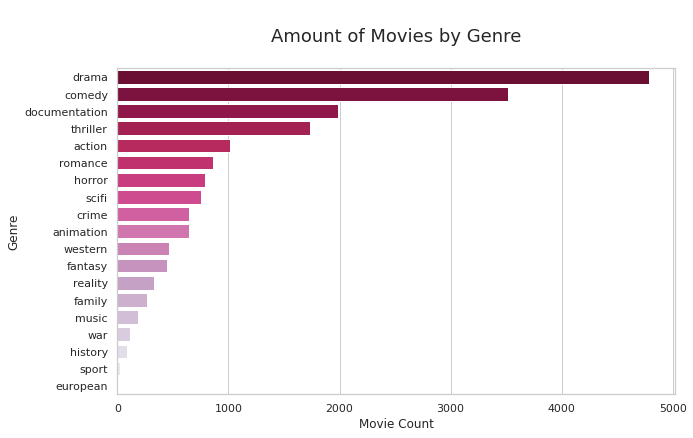

In [27]:
bp_df = pd.DataFrame(df_movies.main_genre.value_counts())
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nAmount of Movies by Genre\n', fontsize=18)
sns.countplot(y=df_movies.main_genre, palette='PuRd_r', order=order)
plt.xlabel('Movie Count')
plt.ylabel('Genre')
plt.show()

### #7 seasons

In [28]:
df_movies.head()

,id,title,type,release_year,runtime,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,lead_prod_country,prod_countries_cnt,main_genre
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,51,1.0,NaN,NaN,NaN,0.600,NaN,US,1,documentation
1,tm84618,Taxi Driver,MOVIE,1976,114,NaN,tt0075314,8.2,808582.0,40.965,8.179,US,1,drama
2,tm154986,Deliverance,MOVIE,1972,109,NaN,tt0068473,7.7,107673.0,10.010,7.300,US,1,drama
3,tm127384,Monty Python and the Holy Grail,MOVIE,1975,91,NaN,tt0071853,8.2,534486.0,15.461,7.811,GB,1,fantasy
4,tm120801,The Dirty Dozen,MOVIE,1967,150,NaN,tt0061578,7.7,72662.0,20.398,7.600,GB,2,war


#### As we see, variable seasons has so many NaN values, because movies do not have seasons. Let's put a 0 here.

In [29]:
df_movies.loc[df_movies['type'] == 'MOVIE', ['seasons']] = 0

<a id="3"></a> <br>
# Feature Engineering

#### Okay, seems like data is more or less clean. Now we're going to transform it for the future clusterisation models.


In [30]:
df_movies.isna().sum()

id                       0
title                    1
type                     0
release_year             0
runtime                  0
seasons                  0
imdb_id               1394
imdb_score            1873
imdb_votes            1910
tmdb_popularity        670
tmdb_score            2656
lead_prod_country     1160
prod_countries_cnt       0
main_genre             321
dtype: int64

#### And starting with getting rid of some NaN value that are still left in our dataset.

In [31]:
df_movies.dropna(inplace=True)

#### Also, set the name of the movie as an index

In [32]:
df_movies.set_index('title', inplace=True)
df_movies.head()

,id,type,release_year,runtime,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,lead_prod_country,prod_countries_cnt,main_genre
title,,,,,,,,,,,,,
Taxi Driver,tm84618,MOVIE,1976,114,0.0,tt0075314,8.2,808582.0,40.965,8.179,US,1,drama
Deliverance,tm154986,MOVIE,1972,109,0.0,tt0068473,7.7,107673.0,10.010,7.300,US,1,drama
Monty Python and the Holy Grail,tm127384,MOVIE,1975,91,0.0,tt0071853,8.2,534486.0,15.461,7.811,GB,1,fantasy
The Dirty Dozen,tm120801,MOVIE,1967,150,0.0,tt0061578,7.7,72662.0,20.398,7.600,GB,2,war
Monty Python's Flying Circus,ts22164,SHOW,1969,30,4.0,tt0063929,8.8,73424.0,17.617,8.306,GB,1,comedy


#### Now let's drop variables that don't have any semantic load -- the ID of the movies and TV shows on different platforms.

In [33]:
df_movies.drop(['id', 'imdb_id'], axis=1, inplace=True)

In [34]:
df_movies.dtypes

type                   object
release_year            int64
runtime                 int64
seasons               float64
imdb_score            float64
imdb_votes            float64
tmdb_popularity       float64
tmdb_score            float64
lead_prod_country      object
prod_countries_cnt      int64
main_genre             object
dtype: object

#### For the three categorical variables that we have now, we create dummy variable -- to represent them as 1s and 0s

In [35]:
dummies = pd.get_dummies(df_movies[['type', 'lead_prod_country', 'main_genre']], drop_first=True)
df_movies_dum = pd.concat([df_movies, dummies], axis=1)
df_movies_dum.drop(['type', 'lead_prod_country', 'main_genre'], axis=1, inplace=True)

#### Now rescale all the variables, so that they fit between 0 and 1

In [36]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_movies_dum)
df_scaled = pd.DataFrame(df_scaled, columns=[df_movies_dum.columns])
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
release_year,14855.0,0.845746,0.205678,0.0,0.827273,0.936364,0.972727,1.0
runtime,14855.0,0.260577,0.106555,0.0,0.182927,0.274390,0.320122,1.0
seasons,14855.0,0.011753,0.039719,0.0,0.000000,0.000000,0.000000,1.0
imdb_score,14855.0,0.592880,0.143532,0.0,0.500000,0.602273,0.693182,1.0
imdb_votes,14855.0,0.010198,0.040940,0.0,0.000146,0.000653,0.003660,1.0
...,...,...,...,...,...,...,...,...
main_genre_scifi,14855.0,0.044362,0.205905,0.0,0.000000,0.000000,0.000000,1.0
main_genre_sport,14855.0,0.000808,0.028411,0.0,0.000000,0.000000,0.000000,1.0
main_genre_thriller,14855.0,0.100909,0.301218,0.0,0.000000,0.000000,0.000000,1.0
main_genre_war,14855.0,0.006328,0.079298,0.0,0.000000,0.000000,0.000000,1.0


In [37]:
df_scaled.shape

(14855, 146)

#### After the encoding we've got 146 variables, which is a relatevely big number. Let's use principal component analysis and see, if we can reduce number of features without much quality loss.

In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=143, svd_solver='full')
df_scaled_full = pca.fit(df_scaled).transform(df_scaled)

explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_),3)

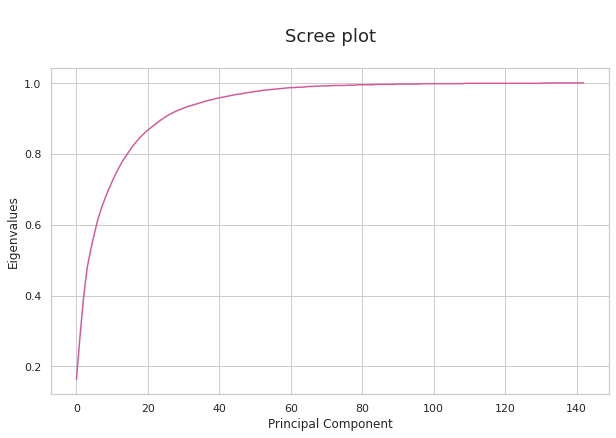

In [39]:
plt.figure(figsize=(10,6))
plt.title('\nScree plot\n', fontsize=18)
plt.plot(np.arange(143), explained_variance, color='#D05C9C')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalues')
plt.show()

#### As we can see from the scree plot, it will be absolutely safe to decrese number of variables to 60, without almost no quality loss.

In [40]:
pca_60 = PCA(n_components=60, svd_solver='full')
df_scaled_60 = pca.fit(df_scaled).transform(df_scaled)

#### And our data df_scaled_60 is all set up for clustering!

<a id="4"></a> <br>
# K-Means

#### To begin with, let's try a simple K-Means clustering model, and look at the elbow curve for the number of clusters from 10 to 80

In [41]:
K = range(10, 80)
models = [KMeans(n_clusters = k, random_state=8, max_iter = 10000).fit(df_scaled_60) for k in K]
dist = [model.inertia_ for model in models]

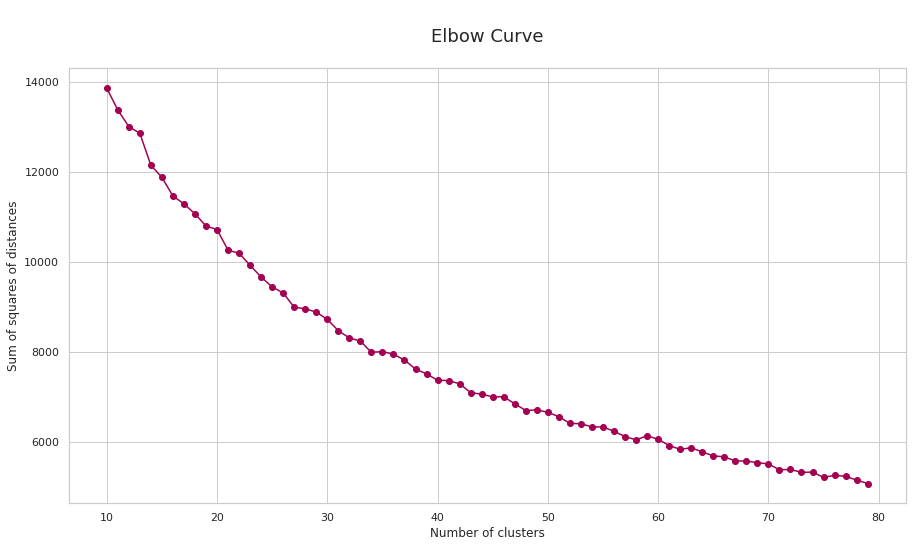

In [42]:
plt.figure(figsize=(15,8))
plt.plot(K, dist, marker='o', color='#a30052')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares of distances')
plt.title('\nElbow Curve\n', fontsize=18)
plt.show()

#### Looks like after about 40 clusters, the curve is more and more flat, and the markers are located closer to each other. So it makes sense to check the values in the range from 20 to 40.

In [43]:
range_n_clusters = range(20, 41, 5)
for n_clusters in range_n_clusters:
    
    models1 = KMeans(n_clusters=n_clusters, random_state=8, max_iter=10000)
    model_labels = models1.fit_predict(df_scaled_60)
    
    silhouette_avg = silhouette_score(df_scaled_60, model_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

For n_clusters = 20 The average silhouette_score is : 0.32575125772453783
For n_clusters = 25 The average silhouette_score is : 0.3395747787705467
For n_clusters = 30 The average silhouette_score is : 0.37160232628200984
For n_clusters = 35 The average silhouette_score is : 0.3940827067955435
For n_clusters = 40 The average silhouette_score is : 0.4114924956955015


#### The average silhouette score is very low, let's try to increase the number of clusters

In [44]:
models_150 = KMeans(n_clusters=150, random_state=8, max_iter = 10000)
model_labels_150 = models_150.fit_predict(df_scaled_60)
silhouette_avg_150 = silhouette_score(df_scaled_60, model_labels_150)
print("For n_clusters =", 150, "The average silhouette_score is :", silhouette_avg_150)

For n_clusters = 150 The average silhouette_score is : 0.4983800824779699


In [45]:
models_300 = KMeans(n_clusters=300, random_state=8, max_iter = 10000)
model_labels_300 = models_300.fit_predict(df_scaled_60)
silhouette_avg_300 = silhouette_score(df_scaled_60, model_labels_300)
print("For n_clusters =", 300, "The average silhouette_score is :", silhouette_avg_300)

For n_clusters = 300 The average silhouette_score is : 0.47274690924234397


#### Well, K-Means shows a rather poor result: even splitting into 300 clusters doesn't give a good value of the silhouette coefficient, and even worse - value drops a little, if we keep increasing amount of clusters.
#### Most likely, a more complex model will be suitable for our data.

<a id="5"></a> <br>
# DBSCAN 10D

In [46]:
from sklearn.decomposition import PCA
pca_10d = PCA(n_components=10)
PCs_10d = pd.DataFrame(pca_10d.fit_transform(df_scaled_60))

eps_array = [0.2, 0.5, 1]
min_samples_array = [5, 10, 30]

In [47]:
for eps in eps_array:
  for min_samples in min_samples_array:
    clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(PCs_10d)
    cluster_labels = clusterer.labels_
    if len(set(cluster_labels)) == 1:
        continue
    silhouette_avg = silhouette_score(PCs_10d, cluster_labels)
    print("For eps =", eps,
          "For min_samples =", min_samples,
          "Count clusters =", len(set(cluster_labels)),
          "The average silhouette_score is :", silhouette_avg)

For eps = 0.2 For min_samples = 5 Count clusters = 64 The average silhouette_score is : 0.7658621112988379
For eps = 0.2 For min_samples = 10 Count clusters = 59 The average silhouette_score is : 0.7683124411968282
For eps = 0.2 For min_samples = 30 Count clusters = 49 The average silhouette_score is : 0.7622294269402919
For eps = 0.5 For min_samples = 5 Count clusters = 49 The average silhouette_score is : 0.7503086554305867
For eps = 0.5 For min_samples = 10 Count clusters = 47 The average silhouette_score is : 0.749075109866969
For eps = 0.5 For min_samples = 30 Count clusters = 39 The average silhouette_score is : 0.7401468871485598


In [48]:
dbscan10d_model = DBSCAN(eps=0.2, min_samples=10).fit(PCs_10d)
print("For eps =", 0.2,
      "For min_samples =", 10,
      "Count clusters =", len(set(dbscan10d_model.labels_)),
      "The average silhouette_score is :", silhouette_score(PCs_10d, dbscan10d_model.labels_))

For eps = 0.2 For min_samples = 10 Count clusters = 59 The average silhouette_score is : 0.7683124411968282


#### 10 Dimentions DBSCAN shows an acceptable score of 0.768. Guess, we can work with that.
#### Let's put the clustering results in the initial movies table.

In [49]:
df_movies[f'{i}_clusters'] = dbscan10d_model.labels_

<a id="6"></a> <br>
# Movie Recommendation Function

#### Our data is ready to use the clustering results to try and recommend a movie by the name of the one you like

In [50]:
def recommend_movie(movie_name: str):
  
  # Define cluster of the input movie
  movie_name = movie_name.lower()
  df_movies['name'] = df_movies.index.str.lower()
  movie = df_movies[df_movies.name.str.contains('dozen') == True] 
  cluster = movie['225635_clusters'][0]
  
  # Get all the movies of the same cluster 
  cluster_movies = df_movies[df_movies['225635_clusters']==cluster]
  
  # Get 5 random movies of the same cluster
  import random
  all_movies = list(cluster_movies.index)
  recommended_movies = random.sample(all_movies, 5)
  for m in recommended_movies:
    print(m)

### 🎉 Now we can input a random movie name and get 5 movies that our model recommends

In [51]:
import sys

if len(sys.argv) > 1:
    s = sys.argv[1]
    print('--- We can recommend you these movies ---')
    recommend_movie(s)
else:
    print('Please provide a movie name as a command-line argument.')

--- We can recommend you these movies ---
Khartoum
The Haunting of Borley Rectory
Alan Partridge: Alpha Papa
The Return of Bulldog Drummond
Break
